In [2]:
import numpy as np
import skimage

In [3]:
import numpy as np
from monai.data.image_reader import ImageReader, ITKReader
from ipywidgets.widgets import *
import ipywidgets as widgets
from monai.visualize.utils import matshow3d
import matplotlib.pyplot as plt
import pytorch_lightning
from monai.utils import set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    ScaleIntensityRanged,
    Spacingd,
    EnsureType,
    EnsureChannelFirstd,
    RandFlipd,
    RandRotated,
    ToTensord,
    Resized,
    RandSpatialCropSamplesd,
    RandRotate90d,
    RandShiftIntensityd,
    KeepLargestConnectedComponent,
    RandCropByPosNegLabeld,
    RandCropByLabelClassesd,
    CastToTyped,
    Rand3DElasticd
)

import wandb
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceFocalLoss, GeneralizedDiceLoss
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, list_data_collate, decollate_batch, Dataset, LMDBDataset
from monai.config import print_config
from monai.apps import download_and_extract
import torch

import os
import glob
from tqdm import tqdm
import numpy as np
from monai.data import DataLoader
import os
import glob
from monai.transforms.spatial.array import Resize

from copy import deepcopy
from enum import Enum
from typing import Any, Dict, Hashable, List, Mapping, Optional, Sequence, Tuple, Union

from monai.config import DtypeLike, KeysCollection
from monai.config.type_definitions import NdarrayOrTensor
from monai.networks.layers import AffineTransform
from monai.networks.layers.simplelayers import GaussianFilter
from monai.transforms.croppad.array import CenterSpatialCrop, SpatialPad
from monai.transforms.inverse import InvertibleTransform
from monai.transforms.spatial.array import (
    Resize,
)
from monai.transforms.transform import MapTransform, RandomizableTransform
from monai.transforms.utils import create_grid
from monai.utils import (
    InterpolateMode,
    ensure_tuple_rep,
)
from monai.utils.deprecate_utils import deprecated_arg
from monai.utils.enums import TraceKeys
from monai.utils.module import optional_import
from monai.utils.type_conversion import convert_data_type, convert_to_dst_type
from monai.apps import load_from_mmar
from monai.apps.mmars import RemoteMMARKeys
from monai.networks.utils import copy_model_state
from monai.optimizers import generate_param_groups
import torch.optim as optim
import time
from pl_bolts.callbacks import PrintTableMetricsCallback
from monai.visualize import matshow3d, blend_images
import imageio
print_config()
from monai.losses import GeneralizedWassersteinDiceLoss
import random

MONAI version: 0.9.0
Numpy version: 1.22.3
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: af0e0e9f757558d144b655c63afcea3a4e0a06f5
MONAI __file__: c:\Users\Vincent Stirler\.conda\envs\env_trauma\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.2.2
scikit-image version: 0.19.2
Pillow version: 9.0.1
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.12.0
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.4.2
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [9]:
label = os.path.join(
    "U:\\", "lauraalvarez", "nnunet", "nnUNet_raw_data", "Task510_LiverTraumaDGX","labelsTs", "TLIV_004.nii.gz"
)

img = os.path.join(
    "U:\\", "lauraalvarez", "nnunet", "nnUNet_raw_data", "Task510_LiverTraumaDGX", "ImagesTs", "TLIV_004_0000.nii.gz"
)

paths = {"label": label, "image": img}
normal_plot = Compose(
    [
        LoadImaged(keys=["image","label"], reader="nibabelreader"),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=[1.0, 1.0, 1.0], mode=("bilinear", "nearest")),
        # RandCropByLabelClassesd(
        #             keys=["image", "label"],
        #             label_key="label",
        #             spatial_size=(96, 96, 96),
        #             ratios=[1,1,2],
        #             num_classes=3,
        #             num_samples=3,
        #         ),
        # RandFlipd(
        #             keys=["image", "label"],
        #             spatial_axis=[2],
        #             prob=0.99,
                # )
    ])

injures = normal_plot(paths)

In [8]:
from sys import getsizeof
getsizeof(injures['image']),getsizeof(injures['label']), injures['image'].shape

(160, 160, (1, 512, 512, 1289))

In [10]:
from sys import getsizeof
#Spacing de 1
getsizeof(injures['image']),getsizeof(injures['label']), injures['image'].shape

(160, 160, (1, 399, 399, 645))

unique values:  [0. 1. 2.]
shape values:  (1, 399, 399, 645) (1, 399, 399, 645)


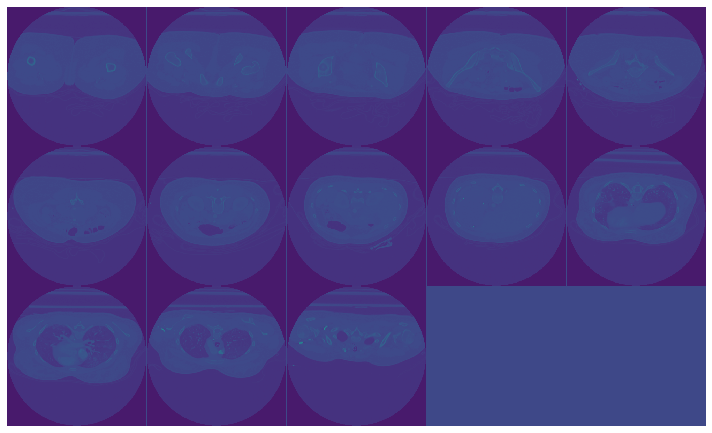

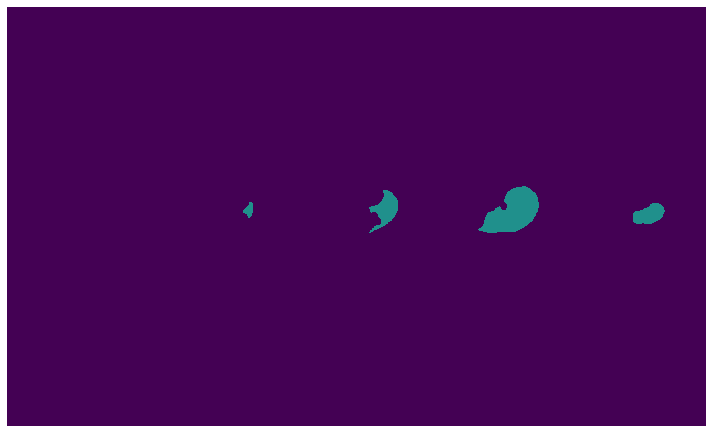

(<Figure size 720x720 with 1 Axes>,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [116]:
out_label = injures['label']
out_img = injures['image']

unique = np.unique(out_label)
print("unique values: ", unique)
print("shape values: ", out_label.shape, out_img.shape)

volume = torch.Tensor(out_img).permute(0, 3, 2, 1).numpy()
matshow3d(volume, frames_per_row=5, every_n=50, show=True, fill_value=0)

volume = torch.Tensor(out_label).permute(0, 3, 2, 1).numpy()
matshow3d(volume, frames_per_row=5, every_n=50, show=True, fill_value=0)

unique values:  [0. 1. 2.]
shape values:  (1, 96, 96, 96) (1, 96, 96, 96)


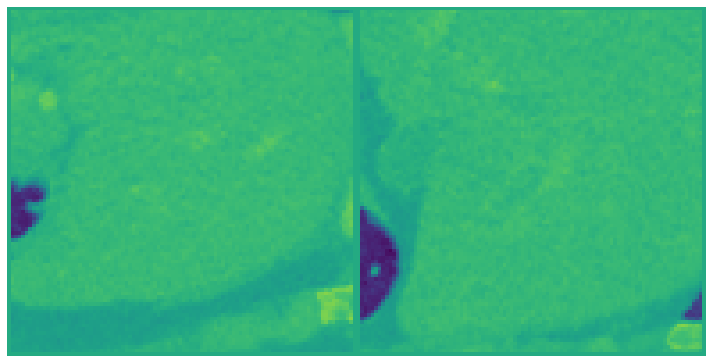

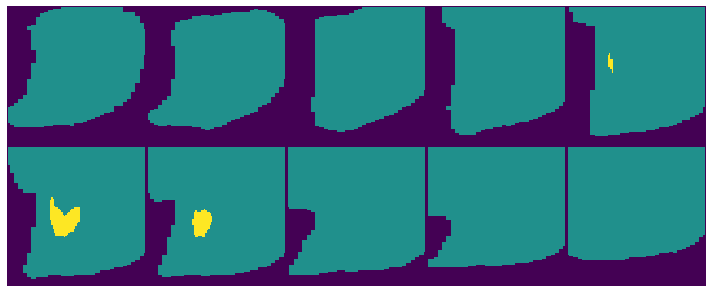

(<Figure size 720x720 with 1 Axes>,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 1., 0.],
        [0., 0., 0., ..., 1., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [100]:
out_label = injures[1]['label']
out_img = injures[1]['image']

unique = np.unique(out_label)
print("unique values: ", unique)

# out_img = torch.Tensor(out_img).permute(0, 2, 1).numpy()
# out_label = torch.Tensor(out_label).permute(0, 2, 1).numpy()
print("shape values: ", out_label.shape, out_img.shape)

from monai.visualize.utils import matshow3d
# volume = torch.Tensor(out_img).permute(2, 1, 0).numpy()
matshow3d(out_img, frames_per_row=5, every_n=50, show=True, fill_value=0)

# volume = torch.Tensor(out_label).permute(2, 1, 0).numpy()
matshow3d(out_label, frames_per_row=5, every_n=10, show=True, fill_value=0)

unique values:  [0. 1.]
shape values:  (1, 96, 96, 96) (1, 96, 96, 96)


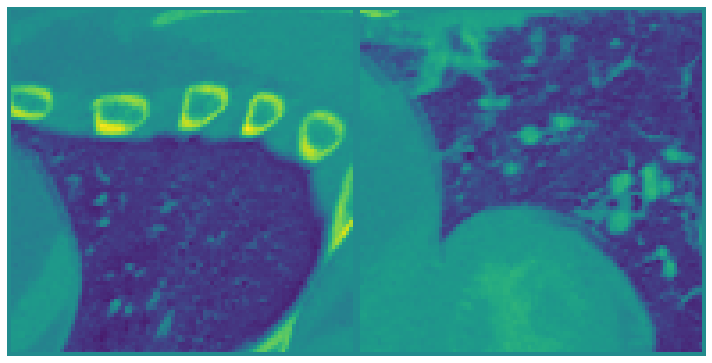

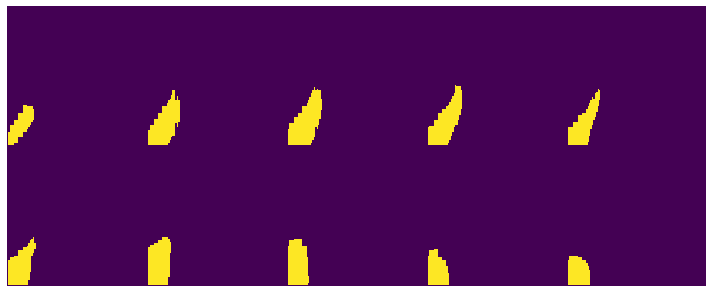

(<Figure size 720x720 with 1 Axes>,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 1., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [101]:
out_label = injures[2]['label']
out_img = injures[2]['image']

unique = np.unique(out_label)
print("unique values: ", unique)

# out_img = torch.Tensor(out_img).permute(0, 2, 1).numpy()
# out_label = torch.Tensor(out_label).permute(0, 2, 1).numpy()
print("shape values: ", out_label.shape, out_img.shape)

from monai.visualize.utils import matshow3d
# volume = torch.Tensor(out_img).permute(2, 1, 0).numpy()
matshow3d(out_img, frames_per_row=5, every_n=50, show=True, fill_value=0)

# volume = torch.Tensor(out_label).permute(2, 1, 0).numpy()
matshow3d(out_label, frames_per_row=5, every_n=10, show=True, fill_value=0)

In [59]:
def dicom_animation(slice):
    f, axarr = plt.subplots(1, 2, figsize=(20, 20))
    axarr[0].imshow(out_label[:, :, slice])
    axarr[1].imshow(out_label[:, :, slice])

interact(dicom_animation, slice=(0, out_label.shape[-1] - 1))


interactive(children=(IntSlider(value=494, description='slice', max=988), Output()), _dom_classes=('widget-int…

<function __main__.dicom_animation(slice)>